In [1]:
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, NBEATSx
from neuralforecast.losses.pytorch import *
from neuralforecast.tsdataset import TimeSeriesDataset

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

/Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-17 11:01:36,040	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-17 11:01:36,084	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
url = "https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingUsingFoundationModels/refs/heads/main/data/walmart_sales_small.csv"

df = pd.read_csv(url, parse_dates=["Date"])
df = df.rename(columns={"Store": "unique_id", "Date":"ds", "Weekly_Sales":"y"})
df.head()

,unique_id,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1.644e+06,0,42.31,2.572,211.096,8.106
1,1,2010-02-12,1.642e+06,1,38.51,2.548,211.242,8.106
2,1,2010-02-19,1.612e+06,0,39.93,2.514,211.289,8.106
3,1,2010-02-26,1.410e+06,0,46.63,2.561,211.320,8.106
4,1,2010-03-05,1.555e+06,0,46.50,2.625,211.350,8.106


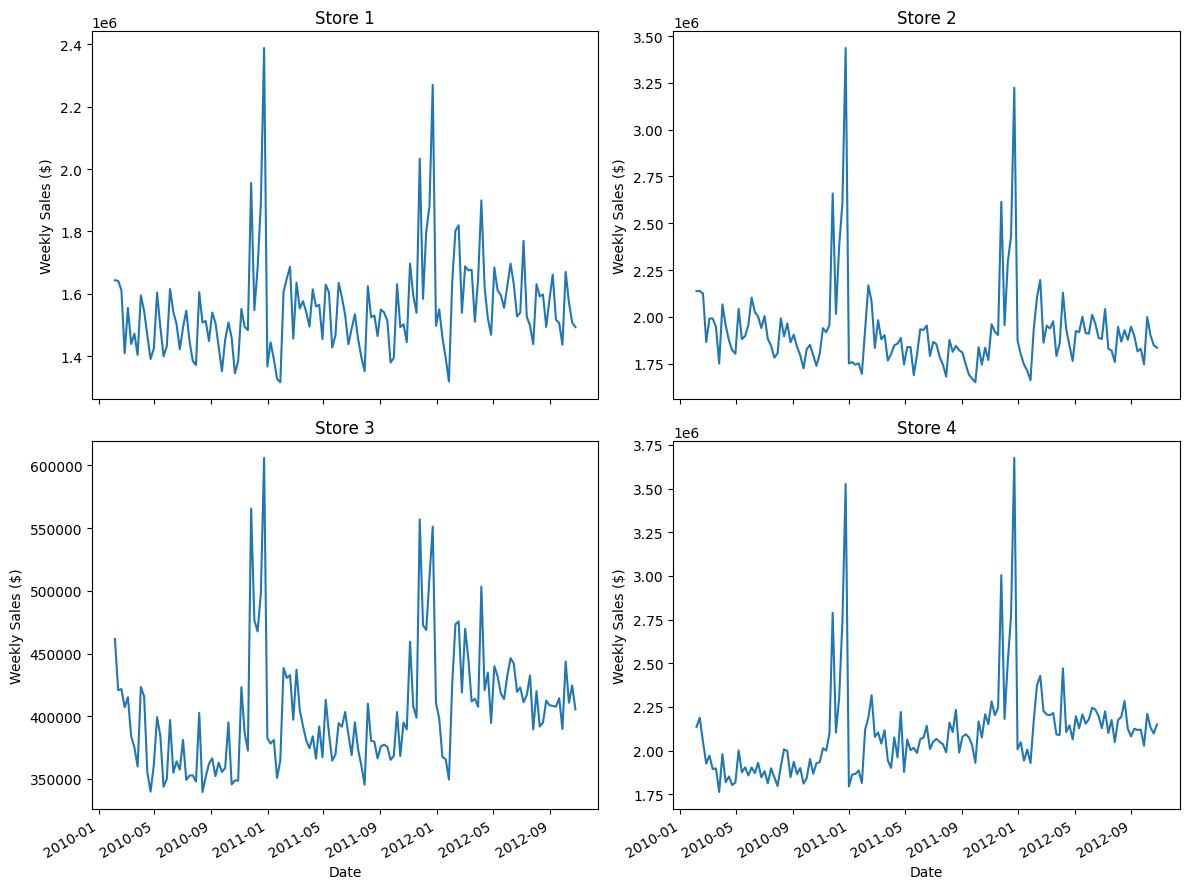

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['unique_id'] == i+1]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

## NBEATS

In [5]:
models = [
    NBEATS(
        h=8,
        input_size=16,
        loss=MAE(),
        max_steps=500,)
]

nf = NeuralForecast(models=models, freq='W')

cv_df = nf.cross_validation(df, n_windows=10, step_size=8)
cv_df.head()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
408       Non-trainable params
2.4 M     Total params
9.681     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 46.77it/s, v_num=92, train_loss_step=4.34e+4, train_loss_epoch=4.34e+4]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s, v_num=92, train_loss_step=4.34e+4, train_loss_epoch=4.34e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.61it/s]


,unique_id,ds,cutoff,NBEATS,y
0,1,2011-04-22,2011-04-15,1.532e+06,1.565e+06
1,1,2011-04-29,2011-04-15,1.448e+06,1.455e+06
2,1,2011-05-06,2011-04-15,1.574e+06,1.629e+06
3,1,2011-05-13,2011-04-15,1.657e+06,1.605e+06
4,1,2011-05-20,2011-04-15,1.612e+06,1.428e+06


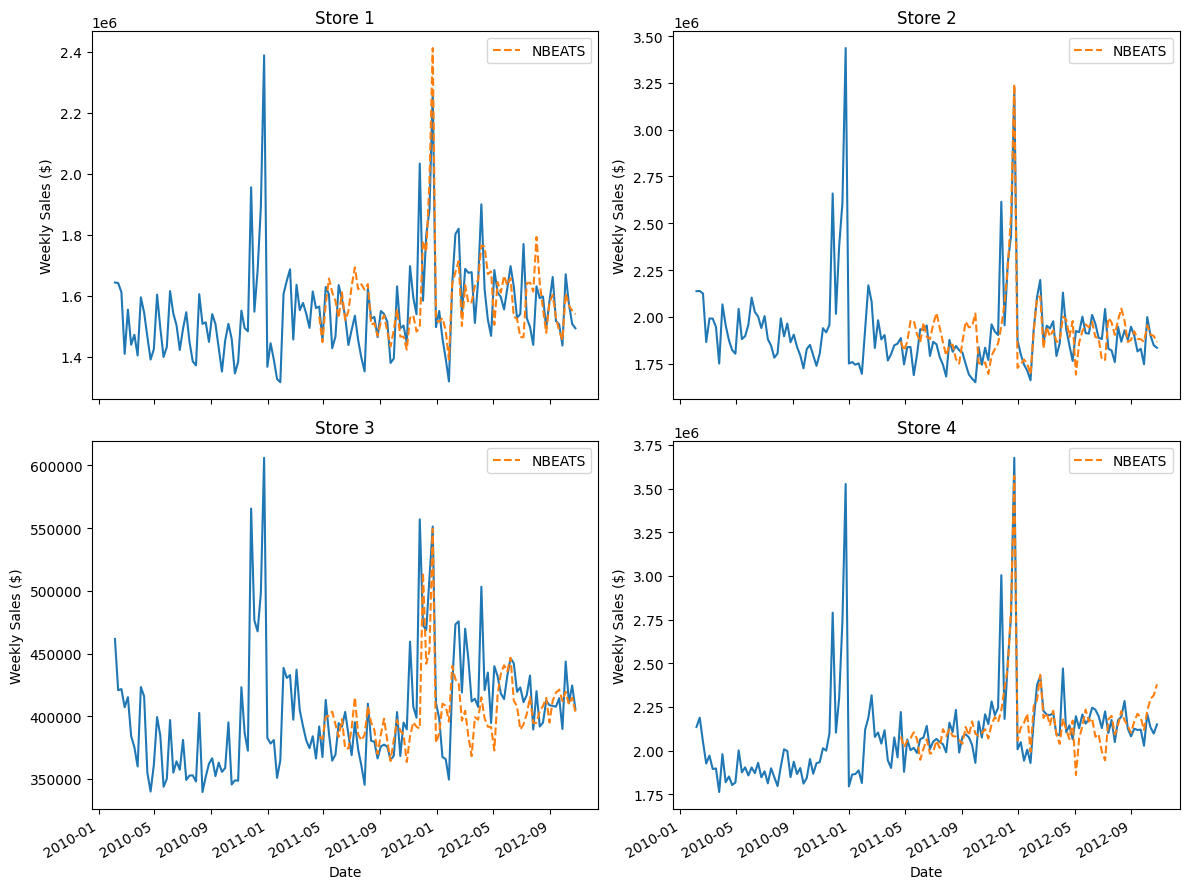

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['unique_id'] == i+1]
    cv_plot_df = cv_df[cv_df['unique_id'] == i+1]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.plot(cv_plot_df['ds'], cv_plot_df['NBEATS'], ls='--', label='NBEATS')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
eval_df = cv_df.drop(['ds', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,NBEATS
0,mae,74342.312
1,smape,0.025


### Interpretable NBEATS

In [8]:
Y_df = df.query("unique_id == 1")
Y_train_df = Y_df[:-32]
Y_test_df = Y_df[-32:]

models = [NBEATSx(h=32,                          
                  input_size=2*32,             
                  loss=MAE(),
                  max_steps=500,
                  dropout_prob_theta=0.5,
                  stack_types=['trend', 'seasonality'], 
                  n_polynomials=0,                      
                  n_blocks=[1, 1],
                  mlp_units=[[64, 64],[64, 64]],
              )
          ]
nf = NeuralForecast(models=models, freq='W')
nf.fit(df=Y_train_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 39.2 K | train
-------------------------------------------------------
33.1 K    Trainable params
6.0 K     Non-trainable params
39.2 K    Total params
0.157     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s, v_num=94, train_loss_step=1.34e+5, train_loss_epoch=1.34e+5]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, v_num=94, train_loss_step=1.34e+5, train_loss_epoch=1.34e+5]


In [9]:
model = nf.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df=Y_train_df)
y_hat = model.decompose(dataset=dataset)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


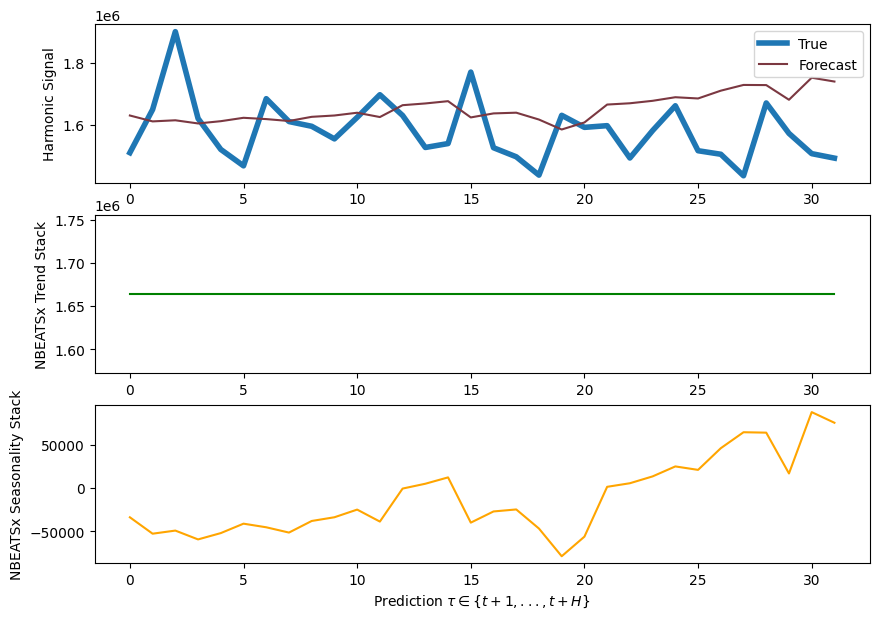

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

ax[0].plot(Y_test_df['y'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,1]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NBEATSx Trend Stack')

ax[2].plot(y_hat[0,2], label='stack2', color="orange")
ax[2].set_ylabel('NBEATSx Seasonality Stack')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()


## NHITS

In [11]:
models = [
    NHITS(
        h=8,
        input_size=16,
        loss=MAE(),
        max_steps=500
    )
]

nf = NeuralForecast(models=models, freq='W')

cv_df = nf.cross_validation(df, n_windows=10, step_size=8)
cv_df.head()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.655     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 36.91it/s, v_num=96, train_loss_step=6.71e+4, train_loss_epoch=6.71e+4]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s, v_num=96, train_loss_step=6.71e+4, train_loss_epoch=6.71e+4]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.07it/s]


,unique_id,ds,cutoff,NHITS,y
0,1,2011-04-22,2011-04-15,1.505e+06,1.565e+06
1,1,2011-04-29,2011-04-15,1.474e+06,1.455e+06
2,1,2011-05-06,2011-04-15,1.533e+06,1.629e+06
3,1,2011-05-13,2011-04-15,1.554e+06,1.605e+06
4,1,2011-05-20,2011-04-15,1.602e+06,1.428e+06


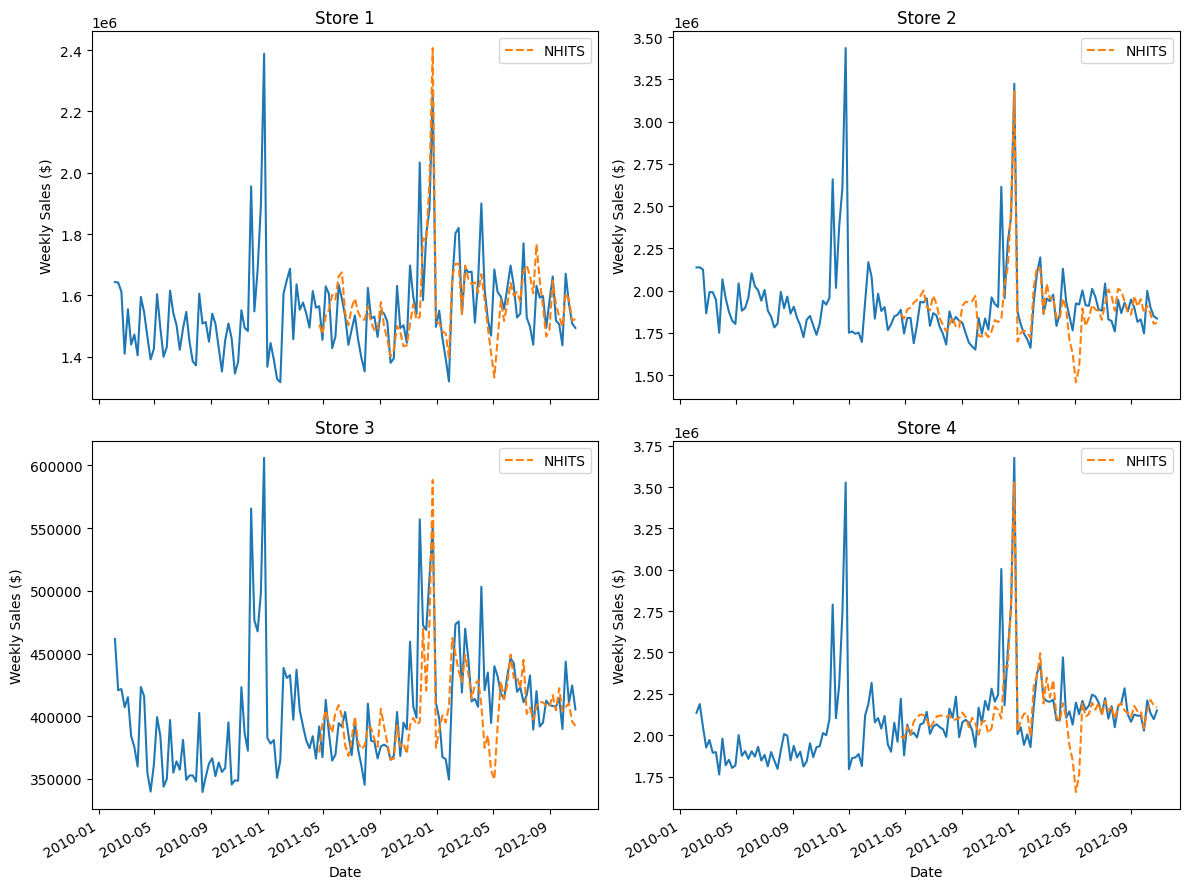

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['unique_id'] == i+1]
    cv_plot_df = cv_df[cv_df['unique_id'] == i+1]

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.plot(cv_plot_df['ds'], cv_plot_df['NHITS'], ls='--', label='NHITS')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
eval_df = cv_df.drop(['ds', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,NHITS
0,mae,73518.724
1,smape,0.025


### Decomposable NHITS

In [14]:
models = [NHITS(h=32,                           
                input_size=2*32,
                loss=MAE(),  
                max_steps=500,
                stack_types=['identity']*2,
                n_blocks=[1, 1],
                mlp_units=[[64, 64],[64, 64]],
                n_freq_downsample=[10, 1], 
              )
          ]
nf = NeuralForecast(models=models, freq='W')
nf.fit(df=Y_train_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 31.5 K | train
-------------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 33.67it/s, v_num=98, train_loss_step=8.74e+4, train_loss_epoch=8.74e+4]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=98, train_loss_step=8.74e+4, train_loss_epoch=8.74e+4]


In [15]:
model = nf.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
y_hat = model.decompose(dataset=dataset)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.73it/s]


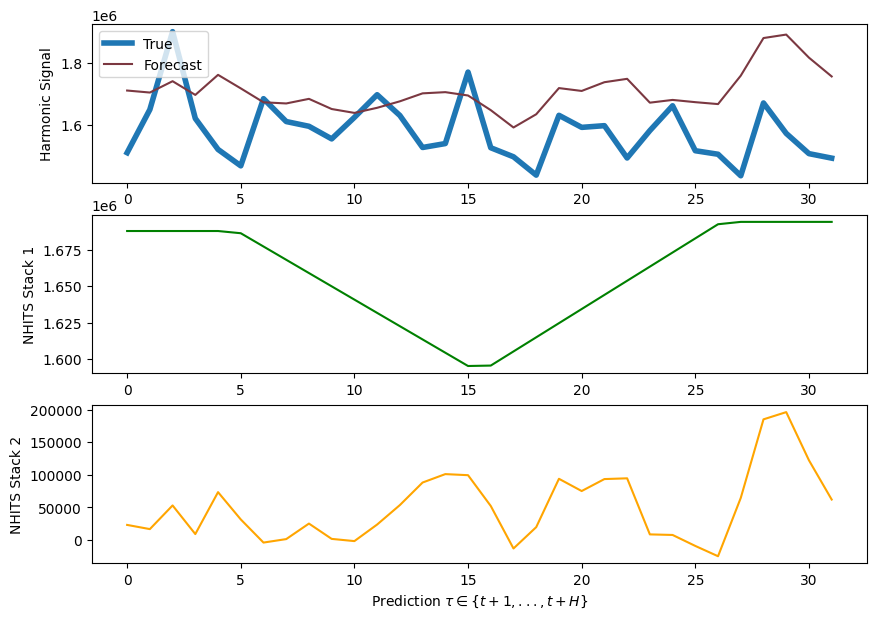

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

ax[0].plot(Y_test_df['y'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,1]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NHITS Stack 1')

ax[2].plot(y_hat[0,2], label='stack2', color="orange")
ax[2].set_ylabel('NHITS Stack 2')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()

## Probabilistic forecasting

In [17]:
models = [
    NHITS(
        h=32,
        input_size=64,
        loss=DistributionLoss(distribution='Normal', level=[90]),
        valid_loss=MAE(),
        max_steps=1000,
    )
]

nf = NeuralForecast(models=models, freq='W')

nf.fit(df=Y_train_df)
preds = nf.predict()
preds.head()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 3      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | blocks       | ModuleList       | 2.6 M  | train
----------------------------------------------------------
2.6 M     Trainable params
3         Non-trainable params
2.6 M     Total params
10.348    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s, v_num=100, train_loss_step=5.05e+7, train_loss_epoch=5.05e+7]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s, v_num=100, train_loss_step=5.05e+7, train_loss_epoch=5.05e+7]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


,unique_id,ds,NHITS,NHITS-median,NHITS-lo-90,NHITS-hi-90
0,1,2012-03-18,1.798e+06,2.044e+06,1.908e+06,1.525e+06
1,1,2012-03-25,1.864e+06,4.117e+06,1.461e+06,2.584e+06
2,1,2012-04-01,3.737e+06,2.242e+06,2.023e+06,4.446e+06
3,1,2012-04-08,5.327e+06,5.710e+06,4.797e+06,5.712e+06
4,1,2012-04-15,2.119e+06,1.977e+06,3.361e+06,2.582e+06


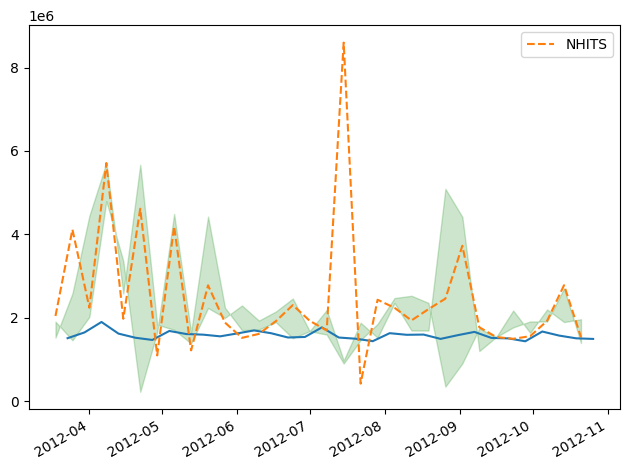

In [18]:
fig, ax = plt.subplots()

ax.plot(Y_test_df['ds'], Y_test_df['y'])
ax.plot(preds['ds'], preds['NHITS-median'], ls='--', label='NHITS')
ax.fill_between(preds['ds'], preds['NHITS-lo-90'], preds['NHITS-hi-90'], color='green', alpha=0.2)
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with exogenous features

In [19]:
Y_test_df.head(1)

,unique_id,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
111,1,2012-03-23,1.511e+06,0,65.93,3.787,221.286,7.348


In [20]:
futr_exog_df = nf.make_future_dataframe()
futr_exog_df['Holiday_Flag'] = Y_test_df['Holiday_Flag'].values

horizon = 32 
models = [
    NHITS(
        h = horizon,
        input_size = 2*horizon,
        futr_exog_list = ['Holiday_Flag'],
        hist_exog_list = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
        scaler_type = 'robust'),
    NBEATSx(
        h = horizon,
        input_size = 2*horizon,
        futr_exog_list = ['Holiday_Flag'],
        hist_exog_list = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
        scaler_type = 'robust',)
]

nf = NeuralForecast(models=models, freq='W')

nf.fit(df=Y_train_df)
futr_exog_df = nf.make_future_dataframe()
futr_exog_df['Holiday_Flag'] = Y_test_df['Holiday_Flag'].values
preds = nf.predict(futr_df=futr_exog_df)
preds.head()


Seed set to 1
Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.9 M  | train
-------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.675    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=102, train_loss_step=0.023, train_loss_epoch=0.023]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 31.10it/s, v_num=102, train_loss_step=0.023, train_loss_epoch=0.023]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
6.2 K     Non-trainable params
3.1 M     Total params
12.506    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 36.11it/s, v_num=103, train_loss_step=0.0284, train_loss_epoch=0.0284]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 34.32it/s, v_num=103, train_loss_step=0.0284, train_loss_epoch=0.0284]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


,unique_id,ds,NHITS,NBEATSx
0,1,2012-03-18,1.685e+06,1.627e+06
1,1,2012-03-25,1.659e+06,1.605e+06
2,1,2012-04-01,1.606e+06,1.573e+06
3,1,2012-04-08,1.627e+06,1.627e+06
4,1,2012-04-15,1.642e+06,1.645e+06


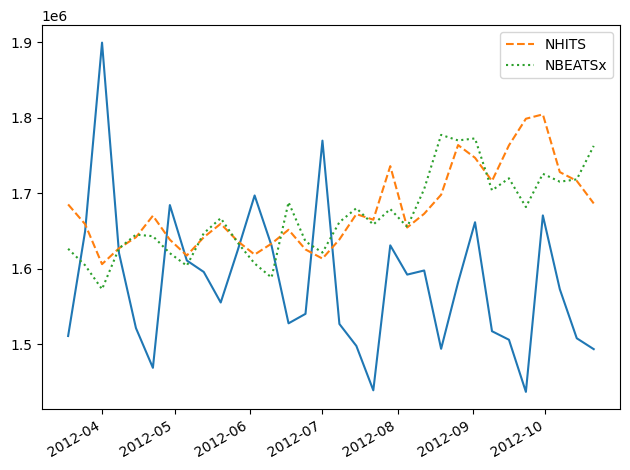

In [21]:
fig, ax = plt.subplots()

ax.plot(preds['ds'], Y_test_df['y'])
ax.plot(preds['ds'], preds['NHITS'], ls='--', label='NHITS')
ax.plot(preds['ds'], preds['NBEATSx'], ls=':', label='NBEATSx')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
preds['y'] = Y_test_df['y'].values

evaluation = evaluate(df=preds, metrics=[mae, smape])
evaluation

,unique_id,metric,NHITS,NBEATSx
0,1,mae,131318.718,132275.057
1,1,smape,0.040,0.041


## Transfer learning

In [23]:
from datasetsforecast.m4 import M4

Y_df, _, _ = M4.load(directory="./", group="Hourly")
Y_df["ds"] = Y_df.groupby("unique_id")["ds"].transform(
    lambda x: pd.date_range(start="1970-01-01", periods=len(x), freq="h")
)
Y_df.head()

,unique_id,ds,y
0,H1,1970-01-01 00:00:00,605.0
1,H1,1970-01-01 01:00:00,586.0
2,H1,1970-01-01 02:00:00,586.0
3,H1,1970-01-01 03:00:00,559.0
4,H1,1970-01-01 04:00:00,511.0


In [24]:
horizon = 48
stacks = 3
models = [
    NHITS(
        input_size=5 * horizon,
        h=horizon,
        max_steps=1000,
        stack_types=stacks * ["identity"],
        n_blocks=stacks * [1],
        mlp_units=[[256, 256] for _ in range(stacks)],
        n_pool_kernel_size=stacks * [1],
        batch_size=32,
        scaler_type="standard",
        n_freq_downsample=[12, 4, 1],
    )
]
nf = NeuralForecast(models=models, freq="h")
nf.fit(df=Y_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 978 K  | train
-------------------------------------------------------
978 K     Trainable params
0         Non-trainable params
978 K     Total params
3.915     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 76:  92%|█████████▏| 12/13 [00:00<00:00, 28.71it/s, v_num=106, train_loss_step=0.203, train_loss_epoch=0.696]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 76:  92%|█████████▏| 12/13 [00:00<00:00, 28.61it/s, v_num=106, train_loss_step=0.203, train_loss_epoch=0.696]


In [25]:
data_url = 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv'
df = pd.read_csv(data_url, parse_dates=['Datetime'])
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df.head()

,unique_id,ds,y
0,PJM,1998-04-01 01:00:00,22259.0
1,PJM,1998-04-01 02:00:00,21244.0
2,PJM,1998-04-01 03:00:00,20651.0
3,PJM,1998-04-01 04:00:00,20421.0
4,PJM,1998-04-01 05:00:00,20713.0


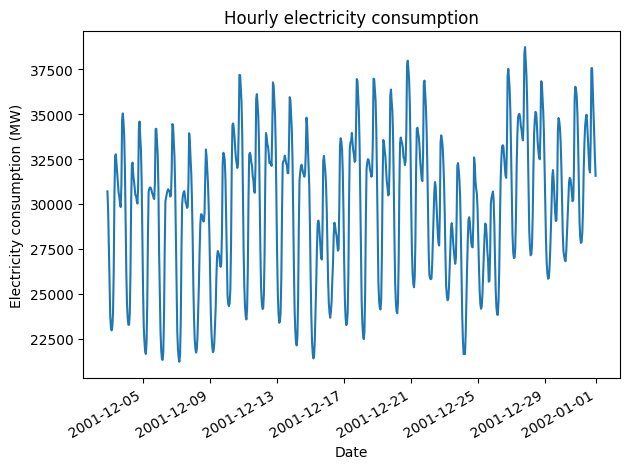

In [26]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-700:], df['y'][-700:])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
input_df = df[:-48]
preds = nf.predict(df=input_df)
preds.head()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


,unique_id,ds,NHITS
0,PJM,2001-12-30 01:00:00,27734.885
1,PJM,2001-12-30 02:00:00,26622.869
2,PJM,2001-12-30 03:00:00,25798.217
3,PJM,2001-12-30 04:00:00,25551.602
4,PJM,2001-12-30 05:00:00,25944.203


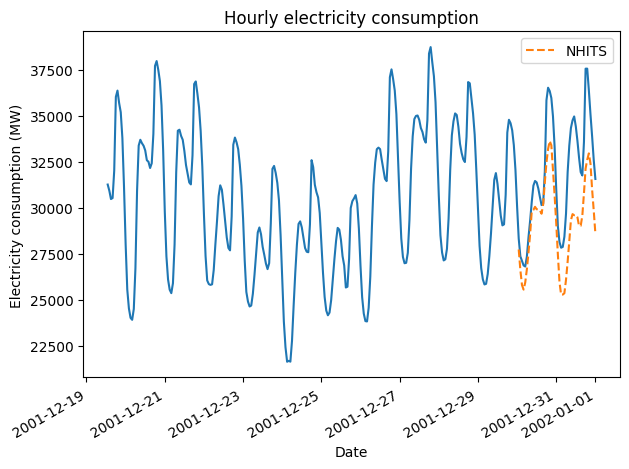

In [28]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-300:], df['y'][-300:])
ax.plot(preds['ds'], preds['NHITS'], ls='--', label='NHITS')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [29]:
horizon = 48
stacks = 3
models = [
    NHITS(
        input_size=5 * horizon,
        h=horizon,
        max_steps=1000,
        stack_types=stacks * ["identity"],
        n_blocks=stacks * [1],
        mlp_units=[[256, 256] for _ in range(stacks)],
        n_pool_kernel_size=stacks * [1],
        batch_size=32,
        scaler_type="standard",
        n_freq_downsample=[12, 4, 1],
    )
]
nf = NeuralForecast(models=models, freq="h")
nf.fit(df=input_df)
preds_trained = nf.predict()
preds_trained.head()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 978 K  | train
-------------------------------------------------------
978 K     Trainable params
0         Non-trainable params
978 K     Total params
3.915     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, v_num=108, train_loss_step=0.176, train_loss_epoch=0.176]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s, v_num=108, train_loss_step=0.176, train_loss_epoch=0.176]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.17it/s]


,unique_id,ds,NHITS
0,PJM,2001-12-30 01:00:00,27843.527
1,PJM,2001-12-30 02:00:00,26865.180
2,PJM,2001-12-30 03:00:00,26306.115
3,PJM,2001-12-30 04:00:00,26125.393
4,PJM,2001-12-30 05:00:00,26490.223


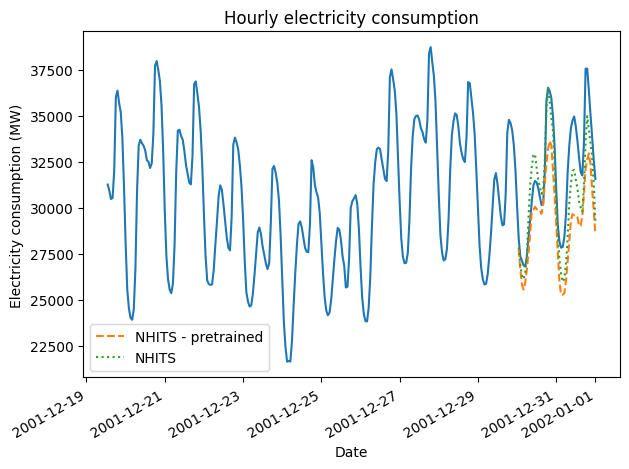

In [30]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-300:], df['y'][-300:])
ax.plot(preds['ds'], preds['NHITS'], ls='--', label='NHITS - pretrained')
ax.plot(preds_trained['ds'], preds_trained['NHITS'], ls=':', label='NHITS')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
test_df = df[-48:]
test_df['NHITS-pretrained'] = preds['NHITS'].values
test_df['NHITS'] = preds_trained['NHITS'].values
test_df.head()

,unique_id,ds,y,NHITS-pretrained,NHITS
32848,PJM,2001-12-30 01:00:00,28326.0,27734.885,27843.527
32849,PJM,2001-12-30 02:00:00,27362.0,26622.869,26865.180
32850,PJM,2001-12-30 03:00:00,27108.0,25798.217,26306.115
32851,PJM,2001-12-30 04:00:00,26865.0,25551.602,26125.393
32852,PJM,2001-12-30 05:00:00,26808.0,25944.203,26490.223


In [32]:
evaluation = evaluate(df=test_df, metrics=[mae, smape])
evaluation

,unique_id,metric,NHITS-pretrained,NHITS
0,PJM,mae,2518.283,1530.238
1,PJM,smape,0.040,0.024


## In-sample predictions

In [34]:
insample_preds = nf.predict_insample(step_size=horizon)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


In [35]:
len(insample_preds)

32832

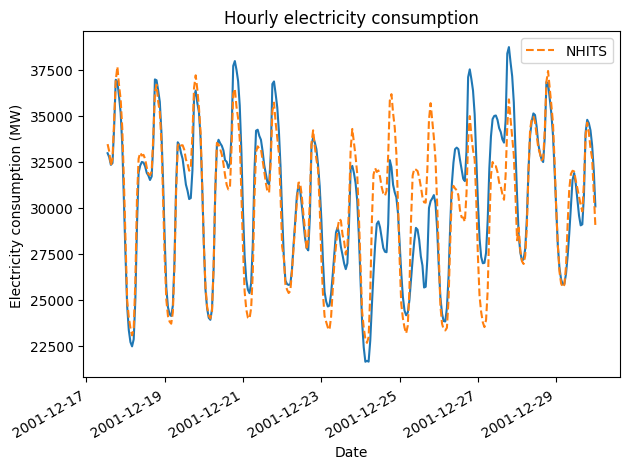

In [41]:
fig, ax = plt.subplots()

ax.plot(input_df['ds'][-300:], input_df['y'][-300:])
ax.plot(insample_preds['ds'][-300:], insample_preds['NHITS'][-300:], ls='--', label='NHITS')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Hyperparameter optimization

In [3]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


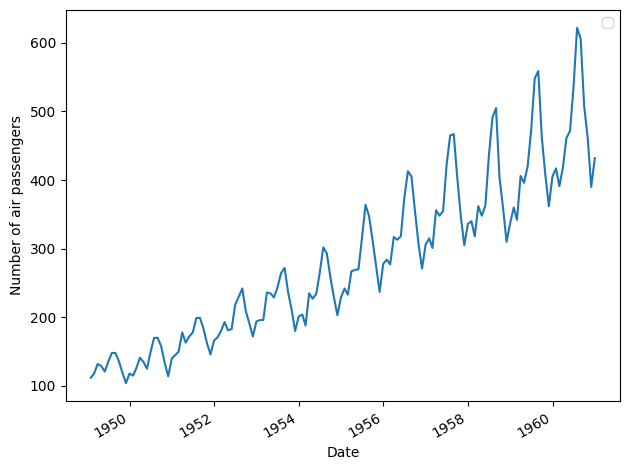

In [4]:
fig, ax = plt.subplots()

ax.plot(Y_df['ds'], Y_df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
from ray import tune
from neuralforecast.auto import AutoNHITS

In [6]:
nhits_config = {
   "max_steps": 100,
   "input_size": tune.choice([24,36]),
   "learning_rate": tune.loguniform(1e-5, 1e-1),
   "random_seed": tune.randint(1, 10),
}

In [7]:
from ray.tune.search.hyperopt import HyperOptSearch

model = AutoNHITS(
    h=12,
    loss=MAE(),
    config=nhits_config,
    search_alg=HyperOptSearch(),
    backend='ray',
    num_samples=10
)

In [8]:
nf = NeuralForecast(models=[model], freq='M')
nf.fit(df=Y_df, val_size=24)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=3069) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3069) Seed set to 6
(_train_tune pid=3069) GPU available: True (mps), used: True
(_train_tune pid=3069) TPU available: False, using: 0 TPU cores
(_train_tune pid=3069) HPU available: False, using: 0 HPUs
(_train_tune pid=3069) 
(_train_tune pid=3069)   | Name         | Type          | Params | Mode 
(_train_tune pid=3069) -------------------------------------------------------
(_train_tune pid=3069) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3069) 1 | padder_train | ConstantPad1d | 0      | train
(_train_tune pid=3069) 2 | scaler       | TemporalNorm  | 0      | train
(_train_tune pid=3069) 3 | blocks       | ModuleList    | 2.5 M  | train
(_train_t

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=11.40, train_loss_epoch=11.40]        


2024-11-17 11:02:01,937	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.37it/s, v_num=0, train_loss_step=11.00, train_loss_epoch=11.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s, v_num=0, train_loss_step=11.00, train_loss_epoch=11.00, valid_loss=19.10]


(_train_tune pid=3069) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=3069) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3069)   warnings.warn('resource_tracker: There appear to be %d '
(_train_tune pid=3087) 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=11.20, train_loss_epoch=11.20]        


2024-11-17 11:02:06,845	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3087) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3087) Seed set to 1
(_train_tune pid=3087) GPU available: True (mps), used: True
(_train_tune pid=3087) TPU available: False, using: 0 TPU cores
(_train_tune pid=3087) HPU available: False, using: 0 HPUs
(_train_tune pid=3087)   | Name         | Type          | Params | Mode 
(_train_tune pid=3087) ------------------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=3087) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3087) 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 67.12it/s, v_num=0, train_loss_step=11.20, train_loss_epoch=10.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=27.40, train_loss_epoch=27.40]        


2024-11-17 11:02:11,691	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3092) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=3092) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3092)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 60.96it/s, v_num=0, train_loss_step=18.90, train_loss_epoch=18.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.89it/s, v_num=0, train_loss_step=18.90, train_loss_epoch=18.90, valid_loss=29.50]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=3103) 
(_train_tune pid=3103) ------------------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=3103) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3103) Seed set to 6
(_train_tune pid=3103) GPU available: True (mps), used: True
(_train_tune pid=3103) TPU available: False, using: 0 TPU cores
(_train_tune pid=3103) HPU available: False, using: 0 HPUs


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=17.60, train_loss_epoch=17.60]        


2024-11-17 11:02:16,689	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3103)   | Name         | Type          | Params | Mode 
(_train_tune pid=3103) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3103) 1 | padder_train | ConstantPad1d | 0      | train
(_train_tune pid=3103) 2 | scaler       | TemporalNorm  | 0      | train
(_train_tune pid=3103) 3 | blocks       | ModuleList    | 2.4 M  | train
(_train_tune pid=3103) 2.4 M     Trainable params
(_train_tune pid=3103) 0         Non-trainable params
(_train_tune pid=3103) 2.4 M     Total params
(_train_tune pid=3103) 9.751     Total estimated model params size (MB)
(_train_tune pid=3103) 34        Modules in train mode
(_train_tune pid=3103) 0         Modules in eval mode
(_train_tune pid=3103) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s, v_num=0, train_loss_step=10.90, train_loss_epoch=11.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s, v_num=0, train_loss_step=10.90, train_loss_epoch=10.90, valid_loss=19.00]


(_train_tune pid=3108) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3108) Seed set to 8
(_train_tune pid=3108) GPU available: True (mps), used: True
(_train_tune pid=3108) TPU available: False, using: 0 TPU cores
(_train_tune pid=3108) HPU available: False, using: 0 HPUs
(_train_tune pid=3103) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3103)   warnings.warn('resource_tracker: There appear to be %d '
(_train_tune pid=3108) 
(_train_tune pid=3108)   | Name         | Type          | Params | Mode 
(_train_tune pid=3108) 0 | loss         | MAE           | 0      | train


Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=40.90, train_loss_epoch=40.90]        


2024-11-17 11:02:21,703	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3108) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=3108) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3108)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.11it/s, v_num=0, train_loss_step=38.90, train_loss_epoch=39.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.61it/s, v_num=0, train_loss_step=38.90, train_loss_epoch=38.90, valid_loss=61.00]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=3113) 
(_train_tune pid=3113) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3113) Seed set to 5
(_train_tune pid=3113) GPU available: True (mps), used: True
(_train_tune pid=3113) TPU available: False, using: 0 TPU cores
(_train_tune pid=3113) HPU available: False, using: 0 HPUs


Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=3.34e+9, train_loss_epoch=3.34e+9]        


2024-11-17 11:02:26,704	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3113)   | Name         | Type          | Params | Mode 
(_train_tune pid=3113) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3113) 1 | padder_train | ConstantPad1d | 0      | train
(_train_tune pid=3113) 2 | scaler       | TemporalNorm  | 0      | train
(_train_tune pid=3113) 3 | blocks       | ModuleList    | 2.5 M  | train
(_train_tune pid=3113) 2.5 M     Trainable params
(_train_tune pid=3113) 0         Non-trainable params
(_train_tune pid=3113) 2.5 M     Total params
(_train_tune pid=3113) 9.874     Total estimated model params size (MB)
(_train_tune pid=3113) 34        Modules in train mode
(_train_tune pid=3113) 0         Modules in eval mode
(_train_tune pid=3113) ------------------------------------------------------- [repeated 2x across clust

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.13it/s, v_num=0, train_loss_step=8.87e+8, train_loss_epoch=1.79e+9]


(_train_tune pid=3118) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3118) Seed set to 7
(_train_tune pid=3113) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=3113) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3113)   warnings.warn('resource_tracker: There appear to be %d '
(_train_tune pid=3118) GPU available: True (mps), used: True
(_train_tune pid=3118) TPU available: False, using: 0 TPU cores
(_train_tune pid=3118) HPU available: False, using: 0 HPUs
(_train_tune pid=3118) 
(_train_tune pid=3118)   | Name         | Type          | Params | Mode 
(_

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s, v_num=0, train_loss_step=29.80, train_loss_epoch=29.80]


2024-11-17 11:02:31,774	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3118) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=3118) ------------------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=3118) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3118)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 64.59it/s, v_num=0, train_loss_step=29.20, train_loss_epoch=29.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s, v_num=0, train_loss_step=29.20, train_loss_epoch=29.20, valid_loss=40.80]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=3127) 
(_train_tune pid=3127) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3127) Seed set to 6
(_train_tune pid=3127) GPU available: True (mps), used: True
(_train_tune pid=3127) TPU available: False, using: 0 TPU cores
(_train_tune pid=3127) HPU available: False, using: 0 HPUs
(_train_tune pid=3127)   | Name         | Type          | Params | Mode 
(_train_tune pid=3127) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3127) 1 | padder_train | ConstantPad1d | 0      | train
(_train_tune pid=3127) 2 | scaler       | TemporalNorm  | 0      | train
(_train_tune pid=3127) 3 | blocks       | ModuleList    | 2.5 M  | train
(_train_tune pid=3127) 2.5 M     Trainable params
(_train_tune pid=3127) 0         Non-t

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s, v_num=0, train_loss_step=28.50, train_loss_epoch=38.90]


2024-11-17 11:02:36,906	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3127) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=3127) ------------------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=3127) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3127)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.80it/s, v_num=0, train_loss_step=8.340, train_loss_epoch=8.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.68it/s, v_num=0, train_loss_step=8.340, train_loss_epoch=8.340, valid_loss=17.20]


(_train_tune pid=3132) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3132) Seed set to 3
(_train_tune pid=3132) GPU available: True (mps), used: True
(_train_tune pid=3132) TPU available: False, using: 0 TPU cores
(_train_tune pid=3132) HPU available: False, using: 0 HPUs
(_train_tune pid=3132) 
(_train_tune pid=3132)   | Name         | Type          | Params | Mode 
(_train_tune pid=3132) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3132) 1 | padder_train | ConstantPad1d | 0      | train
(_train_tune pid=3132) 2 | scaler       | TemporalNorm  | 0      | train
(_train_tune pid=3132) 3 | blocks       | ModuleList    | 2.5 M  | train
(_train_tune pid=3132) 2.5 M     Trainable params
(_train_tune pid=3132) 0         Non-t

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=8.38e+6, train_loss_epoch=8.38e+6]        


(_train_tune pid=3132) `Trainer.fit` stopped: `max_steps=100` reached.
2024-11-17 11:02:41,918	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3132) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=3132)   warnings.warn('resource_tracker: There appear to be %d '
(_train_tune pid=3132) ------------------------------------------------------- [repeated 2x across cluster]


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s, v_num=0, train_loss_step=2.85e+6, train_loss_epoch=3.23e+6]


(_train_tune pid=3139) 
(_train_tune pid=3139) /Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3139) Seed set to 8
(_train_tune pid=3139) GPU available: True (mps), used: True
(_train_tune pid=3139) TPU available: False, using: 0 TPU cores
(_train_tune pid=3139) HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=31.20, train_loss_epoch=31.20]        


2024-11-17 11:02:46,853	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3139)   | Name         | Type          | Params | Mode 
(_train_tune pid=3139) 0 | loss         | MAE           | 0      | train
(_train_tune pid=3139) 1 | padder_train | ConstantPad1d | 0      | train
(_train_tune pid=3139) 2 | scaler       | TemporalNorm  | 0      | train
(_train_tune pid=3139) 3 | blocks       | ModuleList    | 2.4 M  | train
(_train_tune pid=3139) 2.4 M     Trainable params
(_train_tune pid=3139) 0         Non-trainable params
(_train_tune pid=3139) 2.4 M     Total params
(_train_tune pid=3139) 9.751     Total estimated model params size (MB)
(_train_tune pid=3139) 34        Modules in train mode
(_train_tune pid=3139) 0         Modules in eval mode
2024-11-17 11:02:46,860	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.55it/s, v_num=0, train_loss_step=29.00, train_loss_epoch=29.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                               

(_train_tune pid=3139) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.75it/s, v_num=112, train_loss_step=8.990, train_loss_epoch=8.990]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s, v_num=112, train_loss_step=8.990, train_loss_epoch=8.990]


In [23]:
results = nf.models[0].results.get_dataframe()

config_cols = [col for col in results.columns if col.startswith('config')]
columns_to_keep = ['loss', 'train_loss'] + config_cols
existing_columns = [col for col in columns_to_keep if col in results.columns]
filtered_results = results[existing_columns]
best_runs = filtered_results.sort_values('loss', ascending=True).head(5)
best_runs

,loss,train_loss,config/max_steps,config/input_size,config/learning_rate,config/random_seed,config/h,config/loss,config/valid_loss
7,17.217,8.340,100,36,3.276e-03,6,12,MAE(),MAE()
1,17.729,11.197,100,24,1.351e-03,1,12,MAE(),MAE()
3,19.007,10.904,100,24,7.022e-04,6,12,MAE(),MAE()
0,19.095,11.038,100,36,1.293e-03,6,12,MAE(),MAE()
2,29.463,18.886,100,24,6.190e-05,2,12,MAE(),MAE()
